Using PRE_DIR: C:\Users\ahasa\project_root\data\eclss_preprocessed
Using MODEL_DIR: C:\Users\ahasa\project_root\models
Using device: cpu

=== Plotting ROC curve for anomaly detection ===
Loaded VAE weights from: C:\Users\ahasa\project_root\models\vae_dense_eclss.pth


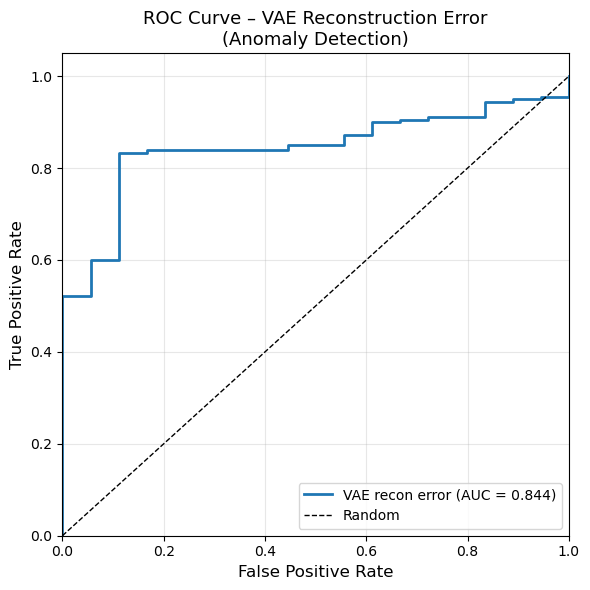

Saved ROC plot to: C:\Users\ahasa\project_root\data\eclss_preprocessed\plot_roc_vae_anomaly.png

=== Plotting reconstruction error histograms ===
Loaded VAE weights from: C:\Users\ahasa\project_root\models\vae_dense_eclss.pth


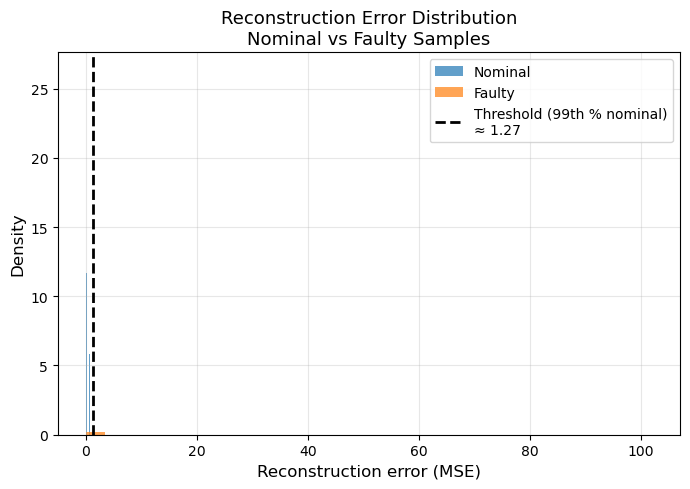

Saved reconstruction histogram to: C:\Users\ahasa\project_root\data\eclss_preprocessed\plot_recon_error_hist.png

=== Plotting SVM fault-type confusion matrix ===
Loaded SVM from:   C:\Users\ahasa\project_root\models\svm_fault_classifier.pkl
Loaded scaler from:C:\Users\ahasa\project_root\models\svm_fault_scaler.pkl
Confusion matrix (rows = true, cols = predicted):
 [[36  0  0  0  0]
 [ 1 34  1  0  0]
 [ 0  3 32  1  0]
 [ 2  0  0 34  0]
 [ 0  0  0  0 36]]

Classification report (per fault type):
              precision    recall  f1-score   support

           1     0.9231    1.0000    0.9600        36
           2     0.9189    0.9444    0.9315        36
           3     0.9697    0.8889    0.9275        36
           4     0.9714    0.9444    0.9577        36
           5     1.0000    1.0000    1.0000        36

    accuracy                         0.9556       180
   macro avg     0.9566    0.9556    0.9554       180
weighted avg     0.9566    0.9556    0.9554       180



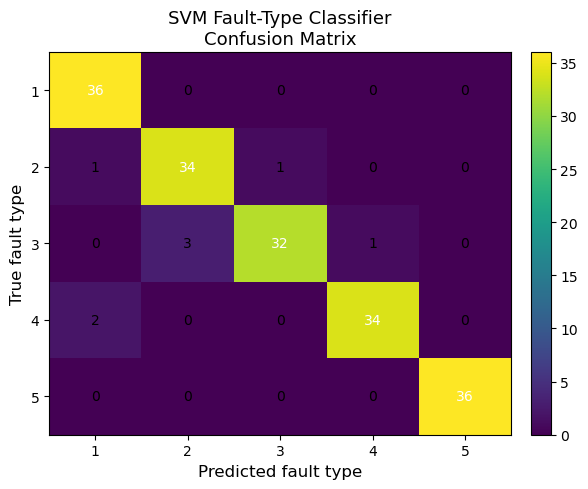

Saved SVM confusion matrix plot to: C:\Users\ahasa\project_root\data\eclss_preprocessed\plot_svm_confusion_matrix.png


In [1]:
# results_plots_eclss.py  (or use as notebook cells)

import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import joblib

# -------------------------------------------------------------------
# 0) Import project modules (VAE & paths)
# -------------------------------------------------------------------
sys.path.append(r"C:\Users\ahasa\project_root")

from train_vae_eclss import (
    DenseVAE,
    cfg,
    PRE_DIR,
    MODEL_DIR,
    compute_reconstruction_errors,
)

print("Using PRE_DIR:", PRE_DIR)
print("Using MODEL_DIR:", MODEL_DIR)
print("Using device:", cfg.device)


# -------------------------------------------------------------------
# 1) Helper: load trained VAE
# -------------------------------------------------------------------
def load_trained_vae() -> DenseVAE:
    model = DenseVAE(
        input_dim=cfg.input_dim,
        hidden_dims=cfg.hidden_dims,
        latent_dim=cfg.latent_dim,
    ).to(cfg.device)

    best_model_path = MODEL_DIR / "vae_dense_eclss.pth"
    model.load_state_dict(torch.load(best_model_path, map_location=cfg.device))
    model.eval()
    print(f"Loaded VAE weights from: {best_model_path}")
    return model


# -------------------------------------------------------------------
# 2) ROC curve for anomaly detection
# -------------------------------------------------------------------
def plot_roc_vae_anomaly():
    print("\n=== Plotting ROC curve for anomaly detection ===")

    X_test_all = np.load(PRE_DIR / "X_test_all_flat.npy")
    y_test_all = np.load(PRE_DIR / "y_test_all_binary.npy")  # 0 = nominal, 1 = anomaly

    model = load_trained_vae()
    errors, _ = compute_reconstruction_errors(model, X_test_all, cfg.device)

    fpr, tpr, _ = roc_curve(y_test_all, errors)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"VAE recon error (AUC = {roc_auc:.3f})", linewidth=2)
    plt.plot([0, 1], [0, 1], "k--", label="Random", linewidth=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title("ROC Curve – VAE Reconstruction Error\n(Anomaly Detection)", fontsize=13)
    plt.grid(alpha=0.3)
    plt.legend(loc="lower right", fontsize=10)
    plt.tight_layout()

    out_path = PRE_DIR / "plot_roc_vae_anomaly.png"
    plt.savefig(out_path, dpi=300)
    plt.show()
    print(f"Saved ROC plot to: {out_path}")


# -------------------------------------------------------------------
# 3) Histogram of reconstruction errors (nominal vs faulty)
# -------------------------------------------------------------------
def plot_reconstruction_hist():
    print("\n=== Plotting reconstruction error histograms ===")

    X_test_all = np.load(PRE_DIR / "X_test_all_flat.npy")
    y_test_all = np.load(PRE_DIR / "y_test_all_binary.npy")  # 0 = nominal, 1 = anomaly

    model = load_trained_vae()
    errors, _ = compute_reconstruction_errors(model, X_test_all, cfg.device)

    err_nom = errors[y_test_all == 0]
    err_fault = errors[y_test_all == 1]

    # Threshold (same as we used before: 99th percentile of nominal TRAIN)
    X_train_nom = np.load(PRE_DIR / "X_train_nom_flat.npy")
    train_errors, _ = compute_reconstruction_errors(model, X_train_nom, cfg.device)
    threshold = np.quantile(train_errors, 0.99)

    plt.figure(figsize=(7, 5))
    bins = 30
    plt.hist(err_nom, bins=bins, alpha=0.7, label="Nominal", density=True)
    plt.hist(err_fault, bins=bins, alpha=0.7, label="Faulty", density=True)
    plt.axvline(threshold, color="k", linestyle="--", linewidth=2,
                label=f"Threshold (99th % nominal)\n≈ {threshold:.2f}")

    plt.xlabel("Reconstruction error (MSE)", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.title("Reconstruction Error Distribution\nNominal vs Faulty Samples", fontsize=13)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()

    out_path = PRE_DIR / "plot_recon_error_hist.png"
    plt.savefig(out_path, dpi=300)
    plt.show()
    print(f"Saved reconstruction histogram to: {out_path}")


# -------------------------------------------------------------------
# 4) Confusion matrix heatmap for SVM fault-type classifier
# -------------------------------------------------------------------
def plot_svm_confusion_matrix():
    print("\n=== Plotting SVM fault-type confusion matrix ===")

    # Latent features & labels for faulty samples
    Z_test_fault = np.load(PRE_DIR / "Z_test_fault.npy")      # shape (150, latent_dim)
    y_test_fault_sys = np.load(PRE_DIR / "y_test_fault_sys.npy")  # values in {1,...,5}

    # Load trained SVM + scaler
    svm_path = MODEL_DIR / "svm_fault_classifier.pkl"
    scaler_path = MODEL_DIR / "svm_fault_scaler.pkl"

    svm = joblib.load(svm_path)
    scaler = joblib.load(scaler_path)
    print(f"Loaded SVM from:   {svm_path}")
    print(f"Loaded scaler from:{scaler_path}")

    Z_test_scaled = scaler.transform(Z_test_fault)
    y_pred = svm.predict(Z_test_scaled)

    labels = [1, 2, 3, 4, 5]
    cm = confusion_matrix(y_test_fault_sys, y_pred, labels=labels)
    print("Confusion matrix (rows = true, cols = predicted):\n", cm)

    print("\nClassification report (per fault type):")
    print(classification_report(y_test_fault_sys, y_pred, digits=4))

    # Plot heatmap
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation="nearest", aspect="auto")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_xlabel("Predicted fault type", fontsize=12)
    ax.set_ylabel("True fault type", fontsize=12)
    ax.set_title("SVM Fault-Type Classifier\nConfusion Matrix", fontsize=13)

    # Annotate cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, cm[i, j],
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2 else "black",
                fontsize=10,
            )

    plt.tight_layout()
    out_path = PRE_DIR / "plot_svm_confusion_matrix.png"
    plt.savefig(out_path, dpi=300)
    plt.show()
    print(f"Saved SVM confusion matrix plot to: {out_path}")


# -------------------------------------------------------------------
# 5) Run everything
# -------------------------------------------------------------------
if __name__ == "__main__":
    plot_roc_vae_anomaly()
    plot_reconstruction_hist()
    plot_svm_confusion_matrix()


Using PRE_DIR: C:\Users\ahasa\project_root\data\eclss_preprocessed
Using MODEL_DIR: C:\Users\ahasa\project_root\models
Using device: cpu

=== Plotting ROC curve for anomaly detection ===
Loaded VAE weights from: C:\Users\ahasa\project_root\models\vae_dense_eclss.pth


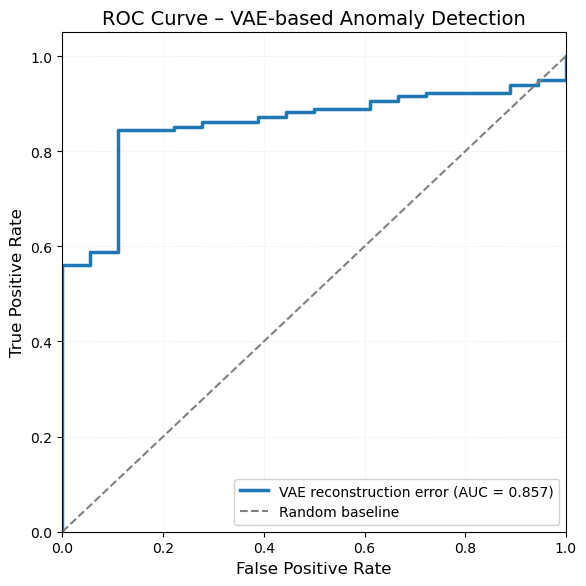

Saved ROC plot to: C:\Users\ahasa\project_root\data\eclss_preprocessed\plot_roc_vae_anomaly.png

=== Plotting reconstruction error histograms ===
Loaded VAE weights from: C:\Users\ahasa\project_root\models\vae_dense_eclss.pth


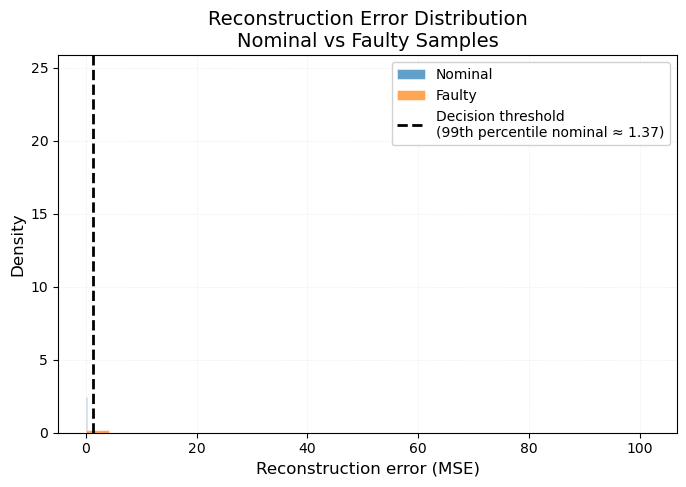

Saved reconstruction histogram to: C:\Users\ahasa\project_root\data\eclss_preprocessed\plot_recon_error_hist.png

=== Plotting SVM fault-type confusion matrix ===
Loaded SVM from:   C:\Users\ahasa\project_root\models\svm_fault_classifier.pkl
Loaded scaler from:C:\Users\ahasa\project_root\models\svm_fault_scaler.pkl
Confusion matrix (rows = true, cols = predicted):
 [[36  0  0  0  0]
 [ 1 34  1  0  0]
 [ 0  3 32  1  0]
 [ 2  0  0 34  0]
 [ 0  0  0  0 36]]

Classification report (per fault type):
              precision    recall  f1-score   support

           1     0.9231    1.0000    0.9600        36
           2     0.9189    0.9444    0.9315        36
           3     0.9697    0.8889    0.9275        36
           4     0.9714    0.9444    0.9577        36
           5     1.0000    1.0000    1.0000        36

    accuracy                         0.9556       180
   macro avg     0.9566    0.9556    0.9554       180
weighted avg     0.9566    0.9556    0.9554       180



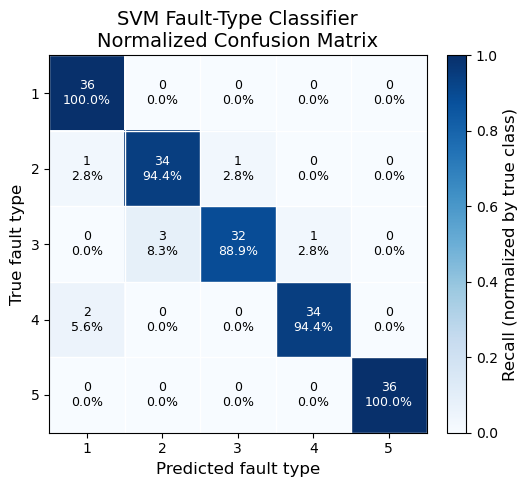

Saved SVM confusion matrix plot to: C:\Users\ahasa\project_root\data\eclss_preprocessed\plot_svm_confusion_matrix.png


In [2]:
# results_plots_eclss.py

import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import joblib

# -------------------------------------------------------------------
# Matplotlib global style
# -------------------------------------------------------------------
plt.rcParams.update({
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "font.size": 11,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

# Simple color palette
COLOR_MAIN = "#1f77b4"   # blue
COLOR_ACCENT = "#ff7f0e" # orange
COLOR_GREY = "#4d4d4d"

# -------------------------------------------------------------------
# 0) Import project modules (VAE & paths)
# -------------------------------------------------------------------
sys.path.append(r"C:\Users\ahasa\project_root")

from train_vae_eclss import (
    DenseVAE,
    cfg,
    PRE_DIR,
    MODEL_DIR,
    compute_reconstruction_errors,
)

print("Using PRE_DIR:", PRE_DIR)
print("Using MODEL_DIR:", MODEL_DIR)
print("Using device:", cfg.device)


# -------------------------------------------------------------------
# 1) Helper: load trained VAE
# -------------------------------------------------------------------
def load_trained_vae() -> DenseVAE:
    model = DenseVAE(
        input_dim=cfg.input_dim,
        hidden_dims=cfg.hidden_dims,
        latent_dim=cfg.latent_dim,
    ).to(cfg.device)

    best_model_path = MODEL_DIR / "vae_dense_eclss.pth"
    model.load_state_dict(torch.load(best_model_path, map_location=cfg.device))
    model.eval()
    print(f"Loaded VAE weights from: {best_model_path}")
    return model


# -------------------------------------------------------------------
# 2) ROC curve for anomaly detection
# -------------------------------------------------------------------
def plot_roc_vae_anomaly():
    print("\n=== Plotting ROC curve for anomaly detection ===")

    X_test_all = np.load(PRE_DIR / "X_test_all_flat.npy")
    y_test_all = np.load(PRE_DIR / "y_test_all_binary.npy")  # 0 = nominal, 1 = anomaly

    model = load_trained_vae()
    errors, _ = compute_reconstruction_errors(model, X_test_all, cfg.device)

    fpr, tpr, _ = roc_curve(y_test_all, errors)
    roc_auc = auc(fpr, tpr)

    fig, ax = plt.subplots(figsize=(6, 6))

    ax.plot(
        fpr,
        tpr,
        label=f"VAE reconstruction error (AUC = {roc_auc:.3f})",
        color=COLOR_MAIN,
        linewidth=2.5,
    )
    ax.plot(
        [0, 1],
        [0, 1],
        linestyle="--",
        color="grey",
        linewidth=1.5,
        label="Random baseline",
    )

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve – VAE-based Anomaly Detection")

    ax.grid(alpha=0.3, linestyle=":", linewidth=0.7)
    ax.legend(loc="lower right", frameon=True, framealpha=0.9)

    fig.tight_layout()
    out_path = PRE_DIR / "plot_roc_vae_anomaly.png"
    fig.savefig(out_path)
    plt.show()
    print(f"Saved ROC plot to: {out_path}")


# -------------------------------------------------------------------
# 3) Histogram of reconstruction errors (nominal vs faulty)
# -------------------------------------------------------------------
def plot_reconstruction_hist():
    print("\n=== Plotting reconstruction error histograms ===")

    X_test_all = np.load(PRE_DIR / "X_test_all_flat.npy")
    y_test_all = np.load(PRE_DIR / "y_test_all_binary.npy")  # 0 = nominal, 1 = anomaly

    model = load_trained_vae()
    errors, _ = compute_reconstruction_errors(model, X_test_all, cfg.device)

    err_nom = errors[y_test_all == 0]
    err_fault = errors[y_test_all == 1]

    # Threshold (same as before: 99th percentile of nominal TRAIN)
    X_train_nom = np.load(PRE_DIR / "X_train_nom_flat.npy")
    train_errors, _ = compute_reconstruction_errors(model, X_train_nom, cfg.device)
    threshold = np.quantile(train_errors, 0.99)

    fig, ax = plt.subplots(figsize=(7, 5))

    bins = 25
    ax.hist(
        err_nom,
        bins=bins,
        alpha=0.7,
        label="Nominal",
        color=COLOR_MAIN,
        density=True,
        edgecolor="white",
        linewidth=0.5,
    )
    ax.hist(
        err_fault,
        bins=bins,
        alpha=0.7,
        label="Faulty",
        color=COLOR_ACCENT,
        density=True,
        edgecolor="white",
        linewidth=0.5,
    )

    ax.axvline(
        threshold,
        color="black",
        linestyle="--",
        linewidth=2,
        label=f"Decision threshold\n(99th percentile nominal ≈ {threshold:.2f})",
    )

    ax.set_xlabel("Reconstruction error (MSE)")
    ax.set_ylabel("Density")
    ax.set_title("Reconstruction Error Distribution\nNominal vs Faulty Samples")
    ax.grid(alpha=0.25, linestyle=":", linewidth=0.7)
    ax.legend(loc="upper right", frameon=True, framealpha=0.9)

    fig.tight_layout()
    out_path = PRE_DIR / "plot_recon_error_hist.png"
    fig.savefig(out_path)
    plt.show()
    print(f"Saved reconstruction histogram to: {out_path}")


# -------------------------------------------------------------------
# 4) Confusion matrix heatmap for SVM fault-type classifier
# -------------------------------------------------------------------
def plot_svm_confusion_matrix():
    print("\n=== Plotting SVM fault-type confusion matrix ===")

    # Latent features & labels for faulty samples
    Z_test_fault = np.load(PRE_DIR / "Z_test_fault.npy")      # shape (150, latent_dim)
    y_test_fault_sys = np.load(PRE_DIR / "y_test_fault_sys.npy")  # values in {1,...,5}

    # Load trained SVM + scaler
    svm_path = MODEL_DIR / "svm_fault_classifier.pkl"
    scaler_path = MODEL_DIR / "svm_fault_scaler.pkl"

    svm = joblib.load(svm_path)
    scaler = joblib.load(scaler_path)
    print(f"Loaded SVM from:   {svm_path}")
    print(f"Loaded scaler from:{scaler_path}")

    Z_test_scaled = scaler.transform(Z_test_fault)
    y_pred = svm.predict(Z_test_scaled)

    labels = [1, 2, 3, 4, 5]
    cm = confusion_matrix(y_test_fault_sys, y_pred, labels=labels)

    print("Confusion matrix (rows = true, cols = predicted):\n", cm)
    print("\nClassification report (per fault type):")
    print(classification_report(y_test_fault_sys, y_pred, digits=4))

    # Normalize for nicer visualization (row-wise)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm_norm, interpolation="nearest", cmap="Blues")

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel("Recall (normalized by true class)", rotation=90)

    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    ax.set_xlabel("Predicted fault type")
    ax.set_ylabel("True fault type")
    ax.set_title("SVM Fault-Type Classifier\nNormalized Confusion Matrix")

    # Minor gridlines to separate cells
    ax.set_xticks(np.arange(-0.5, len(labels), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(labels), 1), minor=True)
    ax.grid(which="minor", color="white", linestyle="-", linewidth=1)
    ax.tick_params(which="minor", bottom=False, left=False)

    # Annotate cells with raw counts and % on new line
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            perc = cm_norm[i, j] * 100
            text = f"{count}\n{perc:.1f}%"
            ax.text(
                j,
                i,
                text,
                ha="center",
                va="center",
                color="white" if cm_norm[i, j] > 0.5 else "black",
                fontsize=9,
            )

    fig.tight_layout()
    out_path = PRE_DIR / "plot_svm_confusion_matrix.png"
    fig.savefig(out_path)
    plt.show()
    print(f"Saved SVM confusion matrix plot to: {out_path}")


# -------------------------------------------------------------------
# 5) Run everything
# -------------------------------------------------------------------
if __name__ == "__main__":
    plot_roc_vae_anomaly()
    plot_reconstruction_hist()
    plot_svm_confusion_matrix()


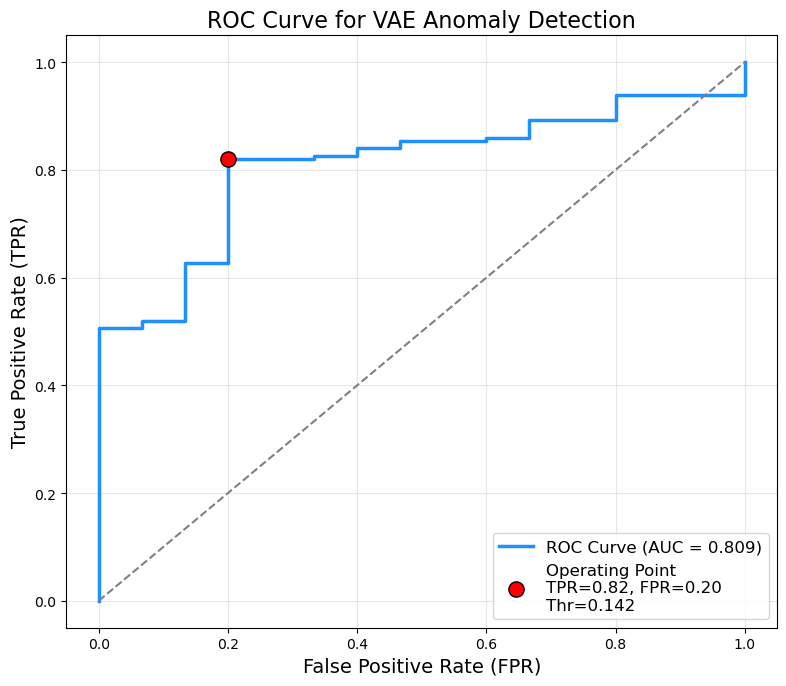

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
from pathlib import Path
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# path to preprocessed folder
PRE_DIR = Path(r"C:\Users\ahasa\project_root\data\eclss_preprocessed")

# Load reconstruction errors & labels
errors = np.load(PRE_DIR / "vae_test_recon_errors.npy")
y_true = np.load(PRE_DIR / "y_test_all_binary.npy")   # 0=nominal, 1=faulty

# already computed these:
# errors = reconstruction errors
# y_true = binary labels

fpr, tpr, thresholds = roc_curve(y_true, errors)
auc = roc_auc_score(y_true, errors)

# ---- Choose the threshold ----
#  Youden's J (best operating point)
j_scores = tpr - fpr
j_best_idx = np.argmax(j_scores)

best_fpr = fpr[j_best_idx]
best_tpr = tpr[j_best_idx]
best_thresh = thresholds[j_best_idx]

# -----------------------------------------------------

plt.figure(figsize=(8, 7))
plt.plot(fpr, tpr, color="dodgerblue", linewidth=2.5, label=f"ROC Curve (AUC = {auc:.3f})")

# Add red dot at the operating point
plt.scatter(
    best_fpr,
    best_tpr,
    color="red",
    s=120,
    edgecolor="black",
    zorder=5,
    label=f"Operating Point\nTPR={best_tpr:.2f}, FPR={best_fpr:.2f}\nThr={best_thresh:.3f}"
)

# Plot diagonal
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate (FPR)", fontsize=14)
plt.ylabel("True Positive Rate (TPR)", fontsize=14)
plt.title("ROC Curve for VAE Anomaly Detection", fontsize=16)
plt.legend(fontsize=12, loc="lower right")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


Nominal errors: min=0.073, max=0.622
Faulty  errors: min=0.054, max=101.744


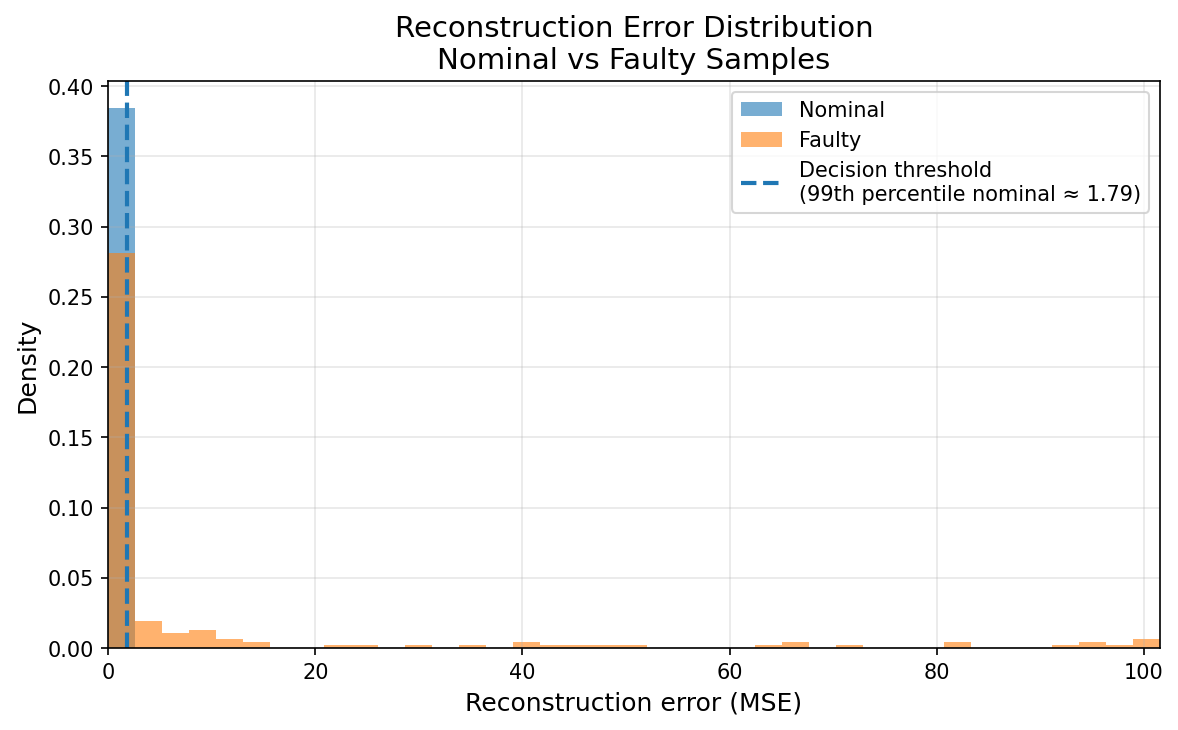

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -----------------------------
# Paths and basic settings
# -----------------------------
PRE_DIR = Path(r"C:\Users\ahasa\project_root\data\eclss_preprocessed")

# Load reconstruction errors and labels from previous VAE run
errors = np.load(PRE_DIR / "vae_test_recon_errors.npy")
y_binary = np.load(PRE_DIR / "y_test_all_binary.npy")   # 0 = nominal, 1 = anomaly

#reload X_train_nom
#printed value:
threshold = 1.79    # 99th percentile of nominal training errors (approx)

# Split errors by class
err_nom = errors[y_binary == 0]
err_fault = errors[y_binary == 1]

print(f"Nominal errors: min={err_nom.min():.3f}, max={err_nom.max():.3f}")
print(f"Faulty  errors: min={err_fault.min():.3f}, max={err_fault.max():.3f}")

# -----------------------------
# Choose a sensible x-range
# -----------------------------
# Use up to the 99.5th percentile of ALL errors so we don’t get stretched by outliers
x_max = np.percentile(errors, 99.5)
x_min = 0.0

bins = np.linspace(x_min, x_max, 40)

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(8, 5), dpi=150)

plt.hist(
    err_nom,
    bins=bins,
    density=True,
    alpha=0.6,
    label="Nominal",
)

plt.hist(
    err_fault,
    bins=bins,
    density=True,
    alpha=0.6,
    label="Faulty",
)

# Decision threshold
plt.axvline(
    threshold,
    linestyle="--",
    linewidth=2,
    label=f"Decision threshold\n(99th percentile nominal ≈ {threshold:.2f})",
)

plt.xlim(x_min, x_max)
plt.xlabel("Reconstruction error (MSE)")
plt.ylabel("Density")
plt.title("Reconstruction Error Distribution\nNominal vs Faulty Samples")

plt.legend(loc="upper right", frameon=True)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()
# plt.savefig(PRE_DIR / "recon_error_hist_pretty.png", bbox_inches="tight", dpi=300)


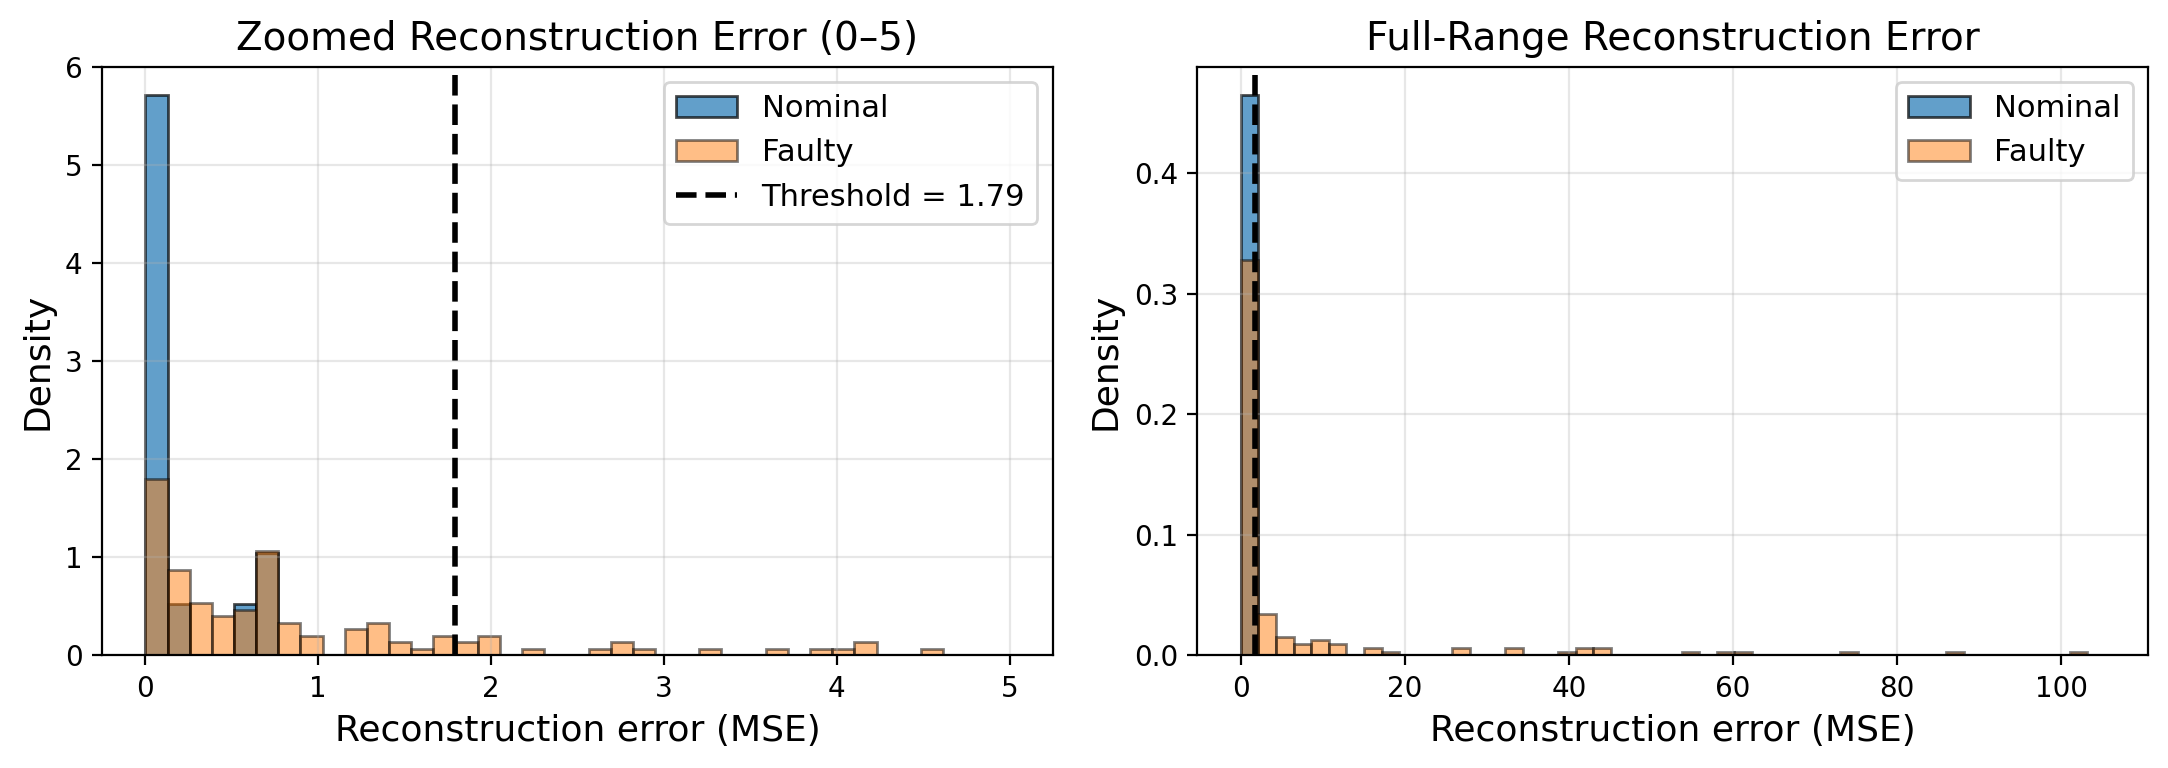

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -------------------------------------------------
# Load reconstruction errors + labels
# -------------------------------------------------
PRE_DIR = Path(r"C:\Users\ahasa\project_root\data\eclss_preprocessed")

errors = np.load(PRE_DIR / "vae_test_recon_errors.npy")
y_bin  = np.load(PRE_DIR / "y_test_all_binary.npy")  # 0=nominal, 1=faulty

err_nom   = errors[y_bin == 0]
err_fault = errors[y_bin == 1]

# Use your chosen threshold (from threshold tuning script)
threshold = 1.79   # update if you changed it

plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 13,
    "legend.fontsize": 11
})

fig, axes = plt.subplots(1, 2, figsize=(11, 4), dpi=200)

# -------------------------------------------------
# (A) Zoomed-in 0–5
# -------------------------------------------------
ax = axes[0]
bins_zoom = np.linspace(0, 5, 40)

ax.hist(err_nom,   bins=bins_zoom, density=True, alpha=0.7,
        label="Nominal", edgecolor="black")
ax.hist(err_fault, bins=bins_zoom, density=True, alpha=0.5,
        label="Faulty", edgecolor="black")

ax.axvline(threshold, linestyle="--", linewidth=2, color="black",
           label=f"Threshold = {threshold:.2f}")

ax.set_title("Zoomed Reconstruction Error (0–5)")
ax.set_xlabel("Reconstruction error (MSE)")
ax.set_ylabel("Density")
ax.grid(alpha=0.3)
ax.legend(frameon=True)

# -------------------------------------------------
# (B) Full range (trim at 99.9th percentile)
# -------------------------------------------------
ax = axes[1]
x_max = np.percentile(errors, 99.9)
bins_full = np.linspace(0, x_max, 50)

ax.hist(err_nom,   bins=bins_full, density=True, alpha=0.7,
        label="Nominal", edgecolor="black")
ax.hist(err_fault, bins=bins_full, density=True, alpha=0.5,
        label="Faulty", edgecolor="black")

ax.axvline(threshold, linestyle="--", linewidth=2, color="black")

ax.set_title("Full-Range Reconstruction Error")
ax.set_xlabel("Reconstruction error (MSE)")
ax.set_ylabel("Density")
ax.grid(alpha=0.3)
ax.legend(frameon=True)

plt.tight_layout()
plt.savefig(PRE_DIR / "plot_recon_error_zoom_full.png", bbox_inches="tight")
plt.show()


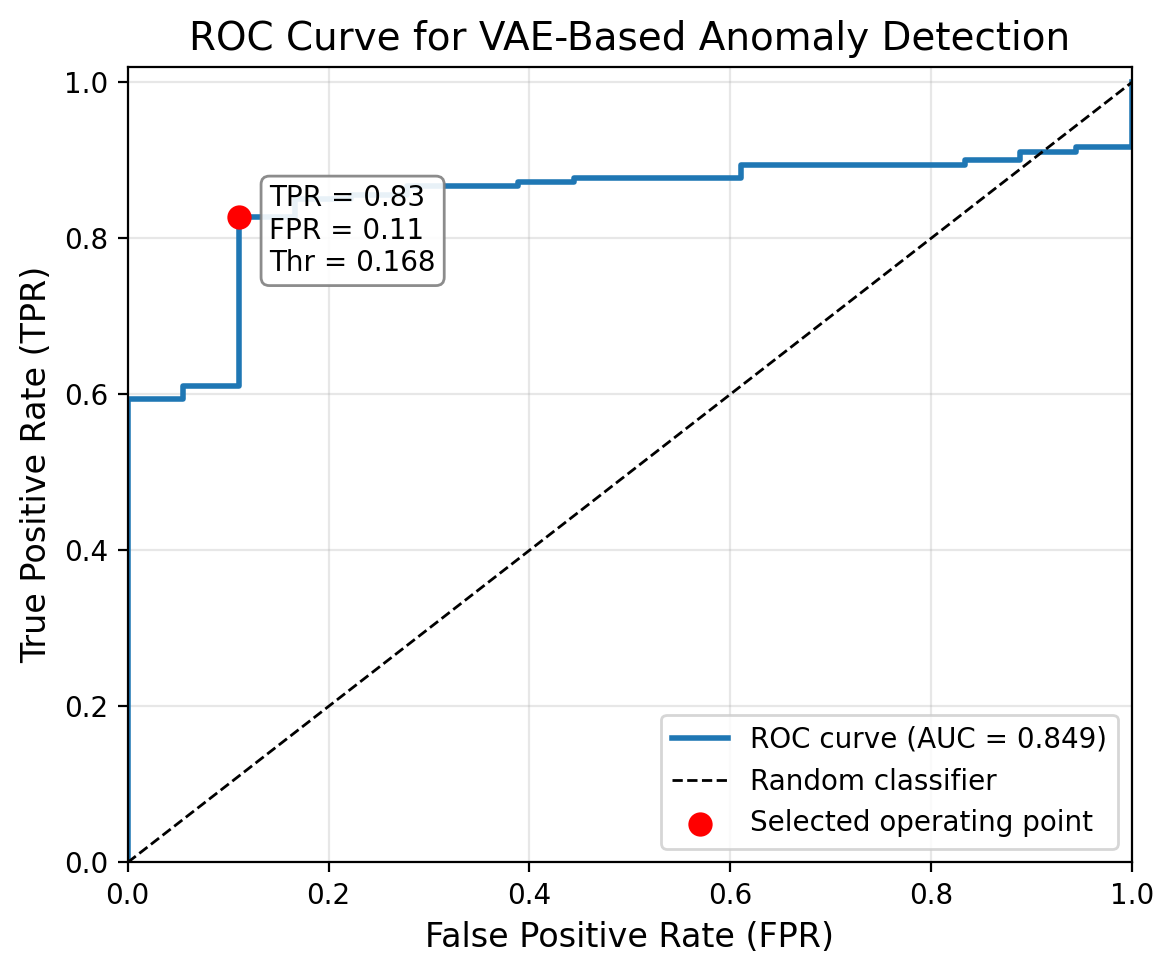

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import roc_curve, roc_auc_score

PRE_DIR = Path(r"C:\Users\ahasa\project_root\data\eclss_preprocessed")

errors = np.load(PRE_DIR / "vae_test_recon_errors.npy")
y_bin  = np.load(PRE_DIR / "y_test_all_binary.npy")

fpr, tpr, thresholds = roc_curve(y_bin, errors)
auc = roc_auc_score(y_bin, errors)

# Pick operating point by Youden’s J (max TPR–FPR)
j_scores = tpr - fpr
idx_best = np.argmax(j_scores)

fpr_best = fpr[idx_best]
tpr_best = tpr[idx_best]
thr_best = thresholds[idx_best]

plt.figure(figsize=(6, 5), dpi=200)

plt.plot(fpr, tpr, linewidth=2, label=f"ROC curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", linewidth=1, label="Random classifier")

# Highlight best operating point
plt.scatter(fpr_best, tpr_best, s=60, color="red", zorder=5, label="Selected operating point")

plt.text(fpr_best + 0.03, tpr_best - 0.07,
         f"TPR = {tpr_best:.2f}\nFPR = {fpr_best:.2f}\nThr = {thr_best:.3f}",
         fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9))

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for VAE-Based Anomaly Detection")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.grid(alpha=0.3)
plt.legend(loc="lower right", frameon=True)

plt.tight_layout()
plt.savefig(PRE_DIR / "plot_roc_vae.png", bbox_inches="tight")
plt.show()


Shapes:
y_true_fault: (180,)
y_pred_fault: (180,)


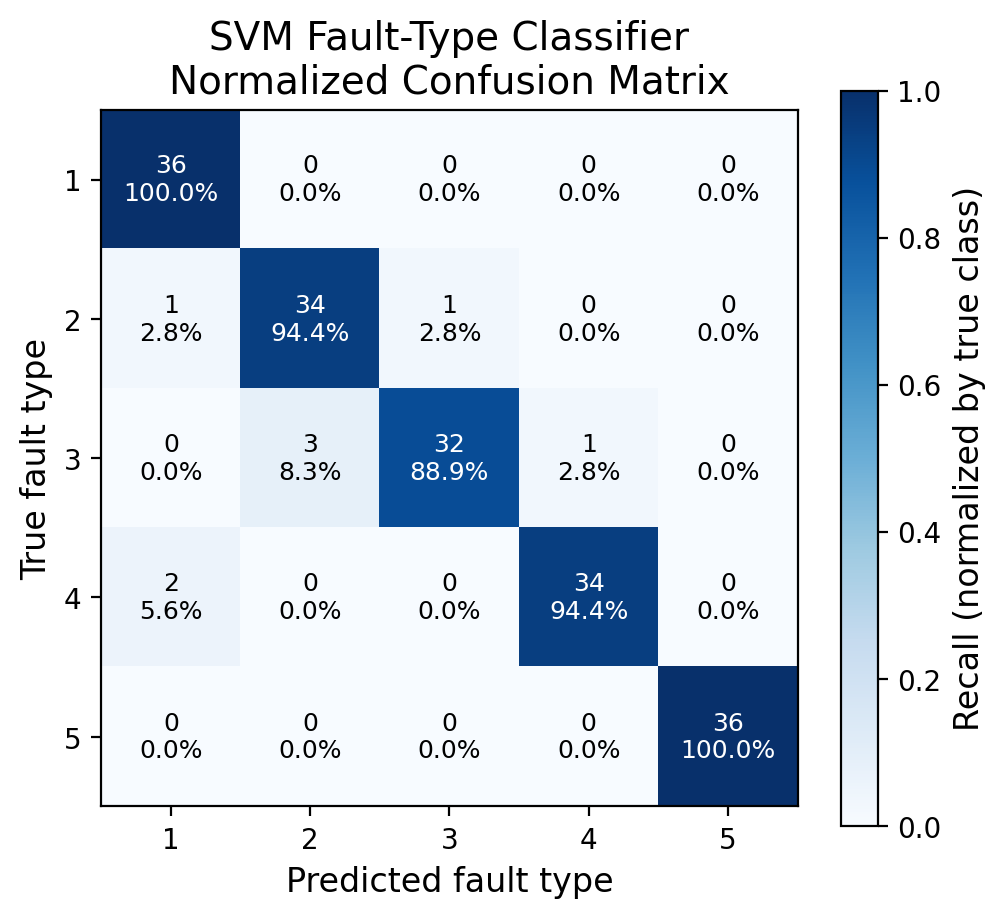

In [5]:
import numpy as np
from pathlib import Path
import joblib

PRE_DIR  = Path(r"C:\Users\ahasa\project_root\data\eclss_preprocessed")
MODEL_DIR = Path(r"C:\Users\ahasa\project_root\models")

# True labels (fault types 1–5, length 150)
y_true_fault = np.load(PRE_DIR / "y_test_fault_sys.npy")

# Load SVM model + scaler
svm = joblib.load(MODEL_DIR / "svm_fault_classifier.pkl")
scaler = joblib.load(MODEL_DIR / "svm_fault_scaler.pkl")

# Load latent test features
Z_test_fault = np.load(PRE_DIR / "Z_test_fault.npy")

# Scale features
Z_test_fault_scaled = scaler.transform(Z_test_fault)

# Predict labels
y_pred_fault = svm.predict(Z_test_fault_scaled)

print("Shapes:")
print("y_true_fault:", y_true_fault.shape)
print("y_pred_fault:", y_pred_fault.shape)


from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

labels = [1, 2, 3, 4, 5]
cm = confusion_matrix(y_true_fault, y_pred_fault, labels=labels)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(5.2, 4.6), dpi=200)
im = ax.imshow(cm_norm, cmap="Blues", vmin=0, vmax=1)

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

ax.set_xlabel("Predicted fault type")
ax.set_ylabel("True fault type")
ax.set_title("SVM Fault-Type Classifier\nNormalized Confusion Matrix")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        perc  = cm_norm[i, j] * 100
        color = "white" if cm_norm[i, j] > 0.5 else "black"
        ax.text(j, i, f"{count}\n{perc:.1f}%", ha="center", va="center", color=color, fontsize=9)

cbar = plt.colorbar(im)
cbar.set_label("Recall (normalized by true class)")

plt.tight_layout()
plt.show()


C:\Users\ahasa\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


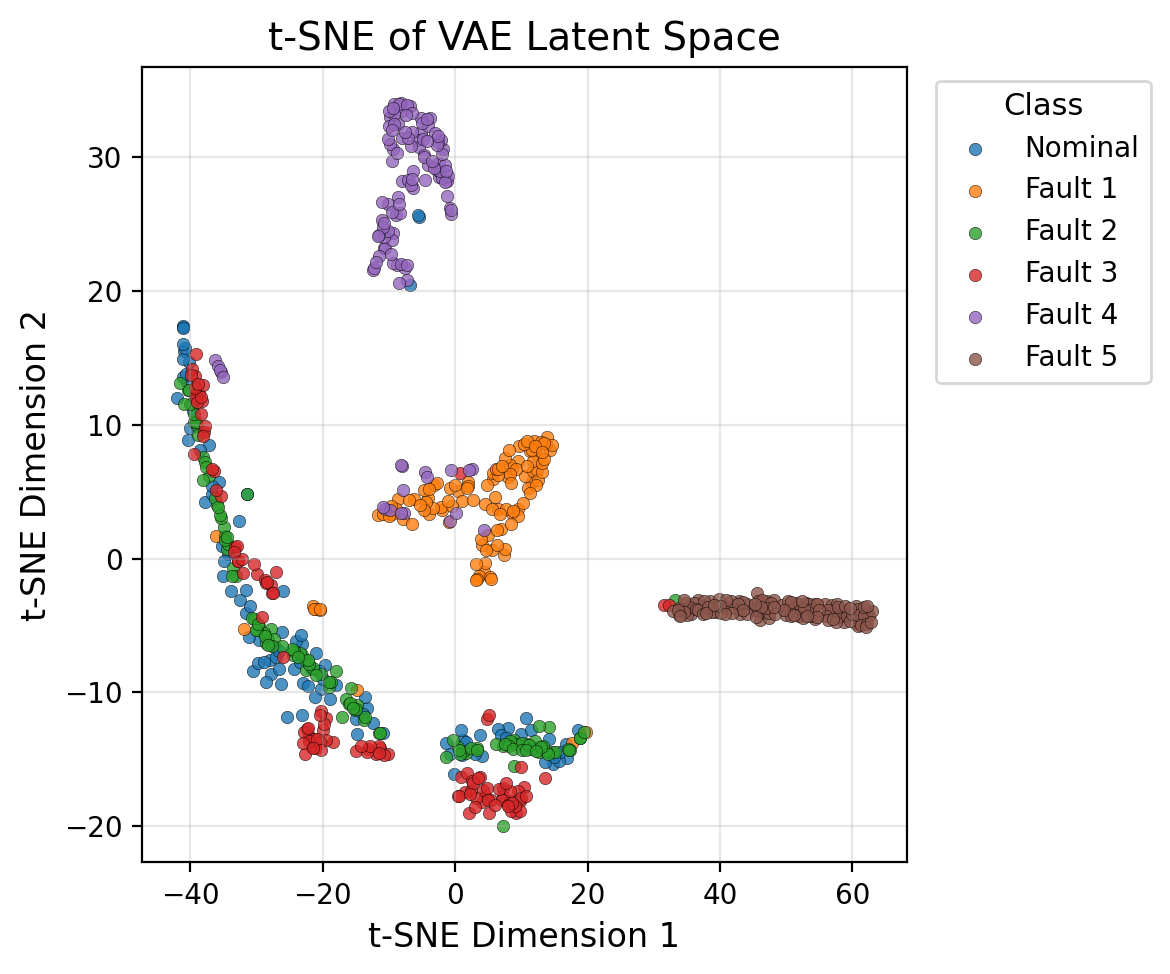

C:\Users\ahasa\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


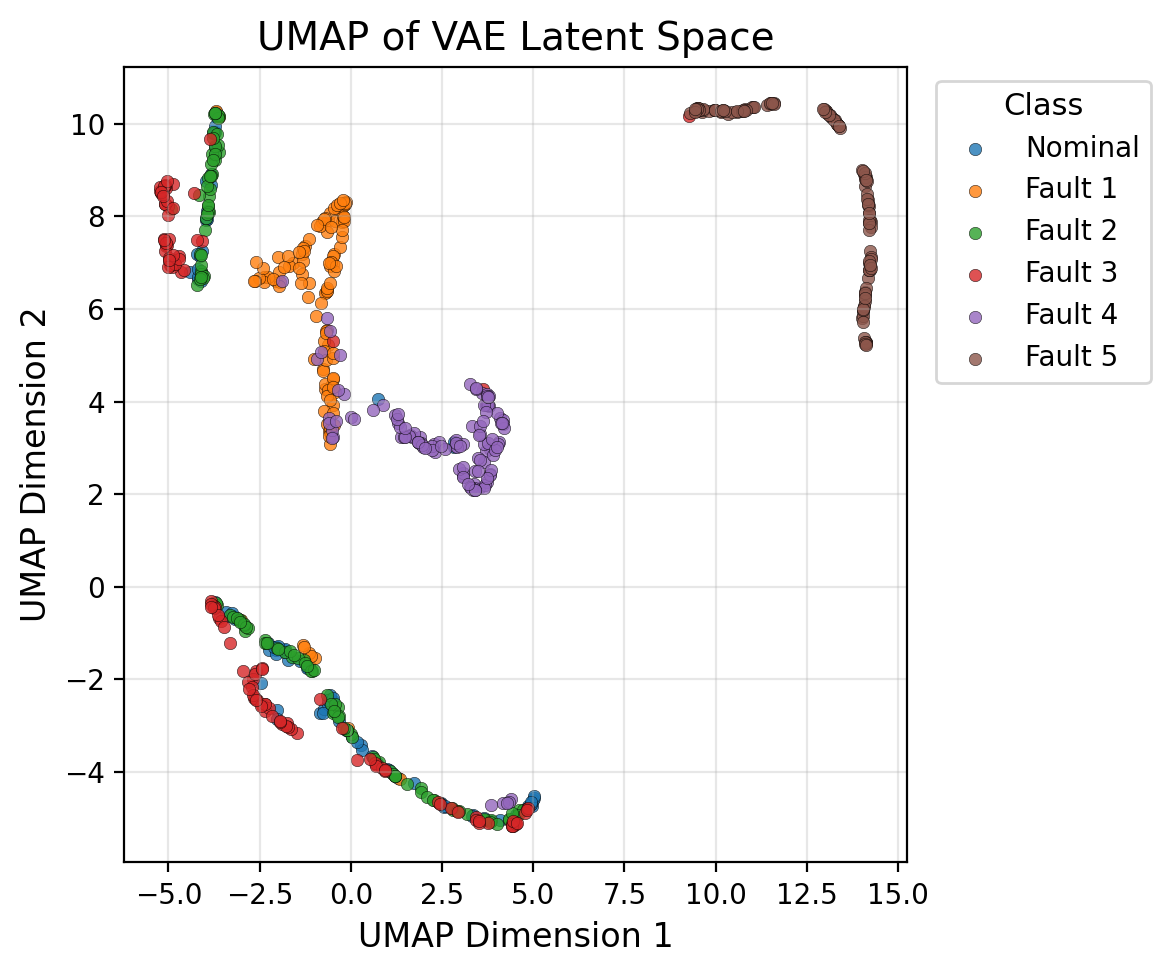

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.manifold import TSNE
import umap   # if not available, skip UMAP part

PRE_DIR = Path(r"C:\Users\ahasa\project_root\data\eclss_preprocessed")

# rebuild combined latent + labels
Z_train_nom   = np.load(PRE_DIR / "Z_train_nom.npy")
Z_train_fault = np.load(PRE_DIR / "Z_train_fault.npy")
Z_test_nom    = np.load(PRE_DIR / "Z_test_nom.npy")
Z_test_fault  = np.load(PRE_DIR / "Z_test_fault.npy")

y_train_fault_sys = np.load(PRE_DIR / "y_train_fault_sys.npy")   # 1–5
y_test_fault_sys  = np.load(PRE_DIR / "y_test_fault_sys.npy")    # 1–5
y_test_nom_sys    = np.load(PRE_DIR / "y_test_nom_sys.npy")      # 0s

Z_all = np.vstack([Z_train_nom, Z_train_fault, Z_test_nom, Z_test_fault])
y_all = np.concatenate([
    np.zeros(len(Z_train_nom), dtype=int),
    y_train_fault_sys,
    np.zeros(len(Z_test_nom), dtype=int),
    y_test_fault_sys
])

classes = [0, 1, 2, 3, 4, 5]
class_names = {
    0: "Nominal",
    1: "Fault 1",
    2: "Fault 2",
    3: "Fault 3",
    4: "Fault 4",
    5: "Fault 5",
}

colors = {
    0: "#1f77b4",  # blue
    1: "#ff7f0e",  # orange
    2: "#2ca02c",  # green
    3: "#d62728",  # red
    4: "#9467bd",  # purple
    5: "#8c564b",  # brown
}

# ---------------- t-SNE ----------------
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200,
            n_iter=2000, random_state=42)

Z_tsne = tsne.fit_transform(Z_all)

plt.figure(figsize=(6, 5), dpi=200)
for c in classes:
    mask = (y_all == c)
    if not np.any(mask):
        continue
    plt.scatter(
        Z_tsne[mask, 0],
        Z_tsne[mask, 1],
        s=20,
        alpha=0.8,
        label=class_names[c],
        edgecolor="k",
        linewidths=0.2,
        color=colors[c],
    )

plt.title("t-SNE of VAE Latent Space")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Class", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(PRE_DIR / "plot_latent_tsne.png", bbox_inches="tight")
plt.show()

# ---------------- UMAP ----------------
reducer = umap.UMAP(
    n_neighbors=20,
    min_dist=0.1,
    n_components=2,
    random_state=42,
)

Z_umap = reducer.fit_transform(Z_all)

plt.figure(figsize=(6, 5), dpi=200)
for c in classes:
    mask = (y_all == c)
    if not np.any(mask):
        continue
    plt.scatter(
        Z_umap[mask, 0],
        Z_umap[mask, 1],
        s=20,
        alpha=0.8,
        label=class_names[c],
        edgecolor="k",
        linewidths=0.2,
        color=colors[c],
    )

plt.title("UMAP of VAE Latent Space")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Class", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(PRE_DIR / "plot_latent_umap.png", bbox_inches="tight")
plt.show()
